#### Using ResNet18 architecture for Cat&Dog Classification Using Small Dataset (500 data points)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn as nn
import numpy as np
import cv2 
from torchsummary import summary
from torchvision import models, transforms,datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
from glob import glob
from random import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [14]:
#import opendatasets as od

In [15]:
#od.download("https://www.kaggle.com/competitions/dogs-vs-cats")

In [16]:
#!unzip dogs-vs-cats/train

In [17]:
#!unzip dogs-vs-cats/-vs-cats/test1 

In [18]:
train_data_dir = "train"
test_data_dir = "test1"

In [19]:
class CatDog(Dataset):
    def __init__(self,folder):
        cats = glob(folder+"/cat*.jpg")
        dogs = glob(folder+"/dog*.jpg")
        self.fpaths = cats[:500]+dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
        
        shuffle(self.fpaths)
        
        self.targets = [path.split("/")[-1].startswith("dog") for path in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, indx):
        image = self.fpaths[indx]
        target = self.targets[indx]
        image = cv2.imread(image)[:,:,::-1]
        image = cv2.resize(image,(128,128))
        image = torch.tensor(image/255)
        image = image.permute(2,0,1)
        image = self.normalize(image)
        
        return image.float().to(device), torch.tensor([target]).float().to(device)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.], device='cuda:0')


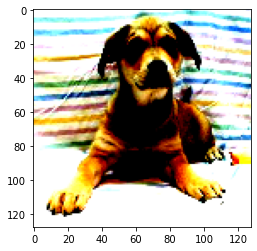

In [20]:
data = CatDog(train_data_dir)
image, label = data[100]
print(label)
plt.imshow(image.permute(1,2,0).cpu())
plt.show()

In [21]:
def build_model():
    resnet18 = models.resnet18(pretrained = True)
    for param in resnet18.parameters():
        param.requires_grad = False
    resnet18.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(1,1))
    resnet18.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(512, 128),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128, 1),
                             nn.Sigmoid())
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(resnet18.parameters(),lr= 1e-3)
    
    return resnet18.to(device) , loss_function, optimizer

In [22]:
model, loss_function, optimizer = build_model()
summary(model, torch.zeros(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          (128)
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          (128)
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    └─BasicBlock: 2-2                   [-1, 64, 32, 32]  

In [23]:
train_data = CatDog(train_data_dir)
train_data_loader = DataLoader(train_data, batch_size=32,shuffle=True,drop_last=True)

In [24]:
def train_batch(x,y,model, loss_function, optimizer):
    model.train()
    predictions = model(x)
    batch_loss = loss_function(predictions, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

In [25]:
def accuracy(x,y,model):
    model.eval()
    predictions = model(x)
    is_correct = (predictions>0.5) ==y
    
    return is_correct.cpu().numpy().tolist()

In [26]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(15):
    print(f"Epoch {epoch + 1}/15")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for batch in (iter(train_data_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model,loss_function,optimizer)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    print(f"Training Loss Value: {train_epoch_loss:0.3f}")
    for batch in (iter(train_data_loader)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)

Epoch 1/15
Training Loss Value: 0.401
Epoch 2/15
Training Loss Value: 0.265
Epoch 3/15
Training Loss Value: 0.315
Epoch 4/15
Training Loss Value: 0.220
Epoch 5/15
Training Loss Value: 0.192
Epoch 6/15
Training Loss Value: 0.236
Epoch 7/15
Training Loss Value: 0.172
Epoch 8/15
Training Loss Value: 0.209
Epoch 9/15
Training Loss Value: 0.153
Epoch 10/15
Training Loss Value: 0.166
Epoch 11/15
Training Loss Value: 0.168
Epoch 12/15
Training Loss Value: 0.134
Epoch 13/15
Training Loss Value: 0.120
Epoch 14/15
Training Loss Value: 0.162
Epoch 15/15
Training Loss Value: 0.126


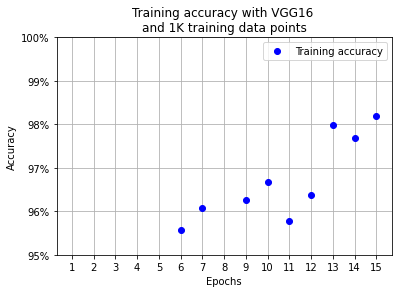

In [27]:
epochs = np.arange(15)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()